<a id="section-one"></a>
# Import packages

In [ ]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")

<a id="section-two"></a>
# Get weekly sentiment for stock ticker

There is much more to the process of stock price formation than plain historical data. Over 1 day, one online post might be a turning point in the course of events, which may result in the market crash. Elon Musk tweets, coronavirus, start of russian full-scale invasion of Ukraine are the proof to that. Therefore, we will take into account another important external indicator, such as the mood of stock market participants. The most effective method in this task is the analysis of the tone (sentiment analysis) of the text, in this notewook we will be consider posts in the social network Twitter.

In [ ]:
stock_name = 'AMZN'

In [ ]:
all_tweets = pd.read_csv('stock_tweets.csv')

In [ ]:
print(all_tweets.shape)
all_tweets.head()

(80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [ ]:
df = all_tweets[all_tweets['Stock Name'] == stock_name]
print(df.shape)
df.head()

(4089, 4)


,Date,Tweet,Stock Name,Company Name
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc."
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc."
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc."
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc."
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc."


In [ ]:
sent_df = df.copy()
sent_df["company_profile"] = 'Amazon.com, Inc. is an American multinational technology company focusing on e-commerce, cloud computing, online advertising, digital streaming, and artificial intelligence. Amazon.com, Inc offers online retail, computing services, consumer electronics, digital content, and other local services such as daily deals and groceries. Headquartered in the United States'
sent_df["sentiment_score_finBert"] = ''
sent_df["Similarity_score"] = ''
sent_df["custom_model_pred"] = ''
sent_df["finBert+similarty_pred"] = ''
sent_df.head()

,Date,Tweet,Stock Name,Company Name,company_profile,sentiment_score_finBert,Similarity_score,custom_model_pred,finBert+similarty_pred
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc.","Amazon.com, Inc. is an American multinational ...",,,,
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc.","Amazon.com, Inc. is an American multinational ...",,,,
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc.","Amazon.com, Inc. is an American multinational ...",,,,
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc.","Amazon.com, Inc. is an American multinational ...",,,,
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc.","Amazon.com, Inc. is an American multinational ...",,,,


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install transformers
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.7 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=86d789b159124465e7a6cf59d096ce9d3cbb633b1abd55e33689f0672837c6e2
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline
from transformers import BertTokenizer, BertForSequenceClassification


In [52]:

# FinBERT for sentiment analysis
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)
# Convert the "Tweet" column to a list of strings
tweets = sent_df["Tweet"].tolist()

# Use the sentiment analysis pipeline
results = nlp(tweets)

# Assign sentiment scores to the "sentiment_score_finBert" column
sent_df["sentiment_score_finBert"] = [result['label'] for result in results]



In [53]:
# Calculate cosine similarity between "Tweet" and "company_profile" embeddings

# Sentence Transformers for similarity scores
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

sent_df["Similarity_score"] = sent_df.apply(lambda row: util.pytorch_cos_sim(model.encode(row["Tweet"]), model.encode(row["company_profile"])).item(), axis=1)
sent_df.head()

,Date,Tweet,Stock Name,Company Name,company_profile,sentiment_score_finBert,Similarity_score,custom_model_pred,finBert+similarty_pred
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc.","Amazon.com, Inc. is an American multinational ...",Neutral,0.378807,,
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc.","Amazon.com, Inc. is an American multinational ...",Positive,0.101364,,
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc.","Amazon.com, Inc. is an American multinational ...",Negative,-0.018661,,
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc.","Amazon.com, Inc. is an American multinational ...",Neutral,0.143386,,
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc.","Amazon.com, Inc. is an American multinational ...",Neutral,0.075790,,


In [55]:


# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tester = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/newsforcompany_pretrain/bert')

# Map predicted labels to human-readable categories
ids_to_labels = {0: "unrelated or related_neutral", 1: "unrelated or related_neutral", 2: "related_negative", 3: "related_positive"}

# Function to evaluate both "Tweet" and "company_profile"
def evaluate_text_pair(model, tweet, company_profile):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    # Tokenize the input sentences
    text = tokenizer.batch_encode_plus(
        list(zip(tweet, company_profile)),
        padding='max_length',
        max_length=512,
        truncation=True
    )

    # Convert the tokenized inputs to PyTorch tensors
    input_id = torch.tensor(text['input_ids']).to(device)
    mask = torch.tensor(text['attention_mask']).to(device)

    # Get predictions from the model
    logits = model(input_id, mask, None)
    logits_clean = logits[0]
    predictions = logits_clean.argmax(dim=1).tolist()
    prediction_label = [ids_to_labels[i] for i in predictions]

    return prediction_label

# Apply the custom model using a for loop
custom_model_predictions = []
for index, row in sent_df.iterrows():
    predictions = evaluate_text_pair(tester, [row["Tweet"]], [row["company_profile"]])
    custom_model_predictions.extend(predictions)

# Add the predictions to the DataFrame
sent_df["custom_model_pred"] = custom_model_predictions

# Print the result or save the modified DataFrame
print(sent_df.head)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

<bound method NDFrame.head of                             Date  \
48351  2022-09-29 22:40:47+00:00   
48352  2022-09-29 22:23:54+00:00   
48353  2022-09-29 18:34:51+00:00   
48354  2022-09-29 15:57:59+00:00   
48355  2022-09-29 15:10:30+00:00   
...                          ...   
52435  2021-09-30 20:50:16+00:00   
52436  2021-09-30 19:45:13+00:00   
52437  2021-09-30 18:01:19+00:00   
52438  2021-09-30 17:56:14+00:00   
52439  2021-09-30 01:59:22+00:00   

                                                   Tweet Stock Name  \
48351  A group of lawmakers led by Sen. Elizabeth War...       AMZN   
48352  $NIO just because I'm down money doesn't mean ...       AMZN   
48353  Today’s drop in $SPX is a perfect example of w...       AMZN   
48354  Druckenmiller owned $CVNA this year \nMunger b...       AMZN   
48355  Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...       AMZN   
...                                                  ...        ...   
52435  My top 10 holdings make up 66% of

In [56]:
sent_df['Date'] = pd.to_datetime(sent_df['Date'])
sent_df['Date'] = sent_df['Date'].dt.date

In [57]:
labels_to_id = { "unrelated or related_neutral":0, "related_negative":1, "related_positive":2}
sent_df["custom_model_pred"] = [labels_to_id[i] for i in sent_df["custom_model_pred"]]
sent_df.head()

,Date,Tweet,Stock Name,Company Name,company_profile,sentiment_score_finBert,Similarity_score,custom_model_pred,finBert+similarty_pred
48351,2022-09-29,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc.","Amazon.com, Inc. is an American multinational ...",0,0.378807,2,0
48352,2022-09-29,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc.","Amazon.com, Inc. is an American multinational ...",2,0.101364,2,2
48353,2022-09-29,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc.","Amazon.com, Inc. is an American multinational ...",1,-0.018661,2,0
48354,2022-09-29,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc.","Amazon.com, Inc. is an American multinational ...",0,0.143386,2,0
48355,2022-09-29,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc.","Amazon.com, Inc. is an American multinational ...",0,0.075790,2,0


In [58]:
# sent_df.to_csv("output_sent_df.csv", index=False)
sent_df2 = pd.read_csv('output_sent_df.csv')
sent_df["custom_model_pred"]  = sent_df2["custom_model_pred"]
sent_df.head()

In [61]:
twitter_df = sent_df.groupby([sent_df['Date']]).mean()
print(twitter_df.shape)

(365, 4)


As the result of sentiment analysis we get average polarity scores of all tweets about a cartain stock ticker for each day:

In [62]:
twitter_df.head()

,sentiment_score_finBert,Similarity_score,custom_model_pred,finBert+similarty_pred
Date,,,,
2021-09-30,0.600000,0.210034,2.0,0.800000
2021-10-01,0.250000,0.063070,2.0,0.250000
2021-10-02,0.666667,0.136669,2.0,0.666667
2021-10-03,0.000000,0.045756,2.0,0.000000
2021-10-04,0.416667,0.093291,2.0,0.500000


In [ ]:
twitter_df['custom_model_pred'] = twitter_df['custom_model_pred'].apply(lambda x: int(x + 0.5) if x >= 0.5 else int(x))
twitter_df['finBert+similarty_pred'] = twitter_df['finBert+similarty_pred'].apply(lambda x: int(x + 0.5) if x >= 0.5 else int(x))
twitter_df.head()

<a id="section-three"></a>
# Get final dataset for training

In [64]:
all_stocks = pd.read_csv('stock_yfinance_data.csv')
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [65]:
stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [66]:
final_df = stock_df.join(twitter_df, how="left", on="Date")
final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)

(252, 11)


In [67]:
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score_finBert,Similarity_score,custom_model_pred,finBert+similarty_pred
1008,2021-09-30,165.800003,166.392502,163.699493,164.251999,164.251999,56848000,0.600000,0.210034,2,1
1009,2021-10-01,164.450500,165.458496,162.796997,164.162994,164.162994,56712000,0.250000,0.063070,2,0
1010,2021-10-04,163.969498,163.999496,158.812500,159.488998,159.488998,90462000,0.416667,0.093291,2,1
1011,2021-10-05,160.225006,163.036499,160.123001,161.050003,161.050003,65384000,0.333333,0.157080,2,0
1012,2021-10-06,160.676498,163.216995,159.931000,163.100494,163.100494,50660000,0.285714,0.176068,1,0


In [68]:
# Create a new column "direction" based on the specified conditions
final_df['direction'] = np.where((final_df['Open'] - final_df['Close']).abs() <= 0.5, 'stay',
                           np.where(final_df['Open'] < final_df['Close'], 'up', 'down'))
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score_finBert,Similarity_score,custom_model_pred,finBert+similarty_pred,direction
1008,2021-09-30,165.800003,166.392502,163.699493,164.251999,164.251999,56848000,0.600000,0.210034,2,1,down
1009,2021-10-01,164.450500,165.458496,162.796997,164.162994,164.162994,56712000,0.250000,0.063070,2,0,stay
1010,2021-10-04,163.969498,163.999496,158.812500,159.488998,159.488998,90462000,0.416667,0.093291,2,1,down
1011,2021-10-05,160.225006,163.036499,160.123001,161.050003,161.050003,65384000,0.333333,0.157080,2,0,up
1012,2021-10-06,160.676498,163.216995,159.931000,163.100494,163.100494,50660000,0.285714,0.176068,1,0,up


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Open'].plot(kind='hist', bins=20, title='Open')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['High'].plot(kind='hist', bins=20, title='High')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Low'].plot(kind='hist', bins=20, title='Low')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Date').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('direction').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='index', y='Open', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Open', y='High', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='High', y='Low', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='Low', y='Close', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Open']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Date')):
  _plot_series(series, series_name, i)
  fig.legend(title='Date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Open')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Open']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('direction')):
  _plot_series(series, series_name, i)
  fig.legend(title='direction', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Open')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['High']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Date')):
  _plot_series(series, series_name, i)
  fig.legend(title='Date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('High')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['High']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('direction')):
  _plot_series(series, series_name, i)
  fig.legend(title='direction', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('High')

from matplotlib import pyplot as plt
_df_14['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Open'].plot(kind='line', figsize=(8, 4), title='Open')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['High'].plot(kind='line', figsize=(8, 4), title='High')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['Low'].plot(kind='line', figsize=(8, 4), title='Low')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['direction'].value_counts()
    for x_label, grp in _df_18.groupby('Date')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Date')
_ = plt.ylabel('direction')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Date'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='index', y='Date', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['direction'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='index', y='direction', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['Date'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='Open', y='Date', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['direction'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='Open', y='direction', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [69]:
id2lbl = {0: "stay", 1: "down", 2: "up"}
final_df['direction'] = [id2lbl[i] for i in final_df['direction']]
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score_finBert,Similarity_score,custom_model_pred,finBert+similarty_pred,direction
1008,2021-09-30,165.800003,166.392502,163.699493,164.251999,164.251999,56848000,0.600000,0.210034,2,1,1
1009,2021-10-01,164.450500,165.458496,162.796997,164.162994,164.162994,56712000,0.250000,0.063070,2,0,0
1010,2021-10-04,163.969498,163.999496,158.812500,159.488998,159.488998,90462000,0.416667,0.093291,2,1,1
1011,2021-10-05,160.225006,163.036499,160.123001,161.050003,161.050003,65384000,0.333333,0.157080,2,0,2
1012,2021-10-06,160.676498,163.216995,159.931000,163.100494,163.100494,50660000,0.285714,0.176068,1,0,2


In [70]:
final_df.to_csv("output_final_df.csv", index=False)
# final_df = pd.read_csv('output_final_df.csv')

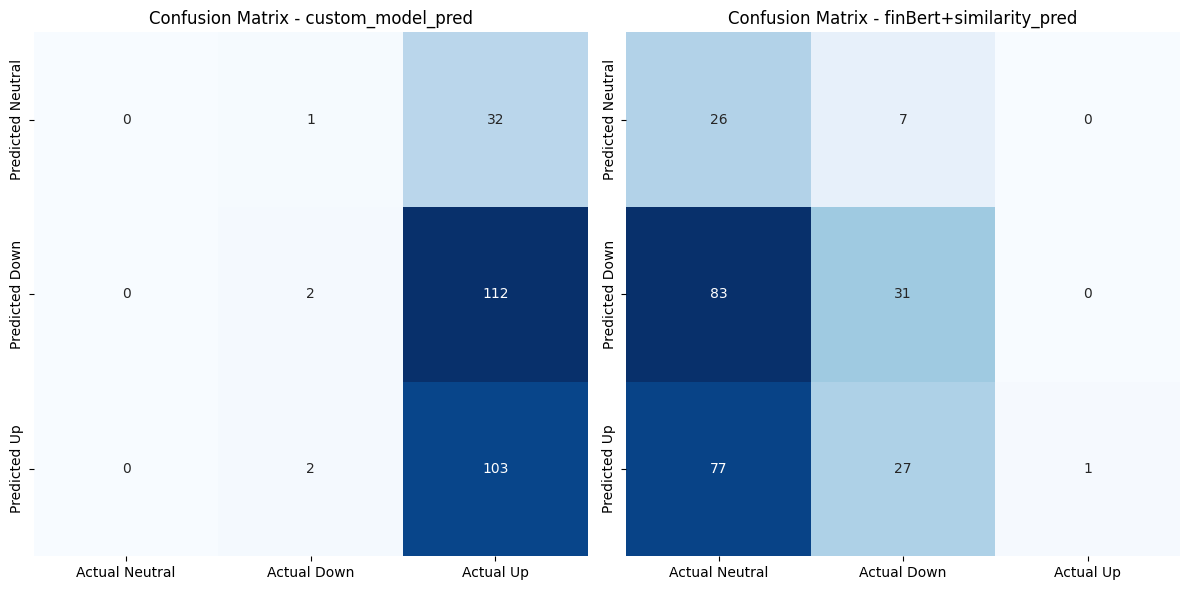

Accuracy - custom_model_pred: 0.4166666666666667
Accuracy - finBert+similarity_pred: 0.23015873015873015


In [77]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming final_df is your DataFrame with columns 'custom_model_pred', 'finBert+similarty_pred', and 'direction'
# Replace final_df with the actual name of your DataFrame

# Extract predictions and true labels
custom_model_pred = final_df['custom_model_pred']
custom_model2_pred = final_df['finBert+similarty_pred']
true_pred = final_df['direction']

# Create confusion matrices
conf_matrix_custom_model = confusion_matrix(true_pred, custom_model_pred)
conf_matrix_custom_model2 = confusion_matrix(true_pred, custom_model2_pred)

# Plot confusion matrices using seaborn
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_custom_model, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Actual Neutral','Actual Down', 'Actual Up'],
            yticklabels=['Predicted Neutral', 'Predicted Down' , 'Predicted Up'])
plt.title('Confusion Matrix - custom_model_pred')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_custom_model2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Actual Neutral','Actual Down', 'Actual Up'],
            yticklabels=['Predicted Neutral', 'Predicted Down' , 'Predicted Up'])
plt.title('Confusion Matrix - finBert+similarity_pred')

plt.tight_layout()
plt.show()

# Calculate accuracy using accuracy_score
accuracy_custom_model = accuracy_score(true_pred, custom_model_pred)
accuracy_custom_model2 = accuracy_score(true_pred, custom_model2_pred)

# Print accuracy
print('Accuracy - custom_model_pred:', accuracy_custom_model)
print('Accuracy - finBert+similarity_pred:', accuracy_custom_model2)